<a href="https://colab.research.google.com/github/Spisor/apuntes-lpp/blob/master/Memoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memoria de desafío

### Grupo formado por

Mario Nieto Pérez, 54205299A

Gilberto Jesús Brito X9541470N

Pablo Aragonés López 53978792T


#Indice

* Introduccion
* Explicación de la red básica - Lenet5
* Funcionamiento básico
 * Image Data Augmentation
 * Cross validation
 * Comparativas con/sin mejoras
* Funcionamiento extendido
 * Clasificación avanzada
 * Pre-procesado de imágenes
 * Ajustes en el algoritmo de optimización
    * Comparativas entre algoritmos
 * Ajustes extra
 * Comparativas entre distintos ajustes
* Mejoras avanzadas
 * Custom data augmentation
 * Uso de redes preentrenadas
* Referencias

#Introducción

El problema que tenemos que resolver consiste en el reconocimiento de imágenes tomadas de los ojos de pacientes donde tenemos que distinguir si el paciente tiene o no retinopatia diabética.

Esta enfermedad ocurre porque los niveles altos de azúcar en la sangre causan daño a los vasos sanguíneos en la retina. Estos vasos sanguíneos pueden hincharse y tener fugas de líquido. También pueden cerrarse e impedir que la sangre fluya. A veces, se generan nuevos vasos sanguíneos anormales en la retina. Todos estos cambios pueden hacerle perder la visión.

Aquí tenemos una imágen comparando un ojo sano con un ojo enfermo:

![texto alternativo](https://medlineplus.gov/spanish/ency/images/ency/fullsize/17150.jpg)

En nuestro problema, la versión simplificada consistirá en discernir entre un ojo enfermo y un ojo sano. En el caso complejo, tenemos que discernir entre 4 posibilidades:

* Sano
* Poco enfermo
* Enfermo
* Muy enfermo


#Explicación de red básica - Lenet5

Lenet5 es una de las redes neuronales más conocidas en el mundo del deep learning. Está ha sido empleada en multitud de problemas, empleandola como base para distintos problemas. Entre los más conocidos tenemos el reconocimiento de digitos en documentos escritos.

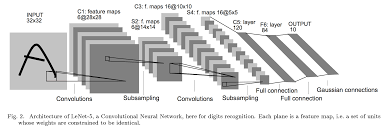

La red está compuesta de la siguiente estructura:

* Convolucion

* Max pooling

* Convolucion

* Max pooling

* Flatten

* Dense

* Dense

* Dense

Esta estructura básica es de la que vamos a partir para el problema que tenemos nosotros.


#Funcionamiento básico


###Image Data Augmentation

Una de las primeras mejoras que hemos añadido ha sido para solventar uno de los problemas iniciales del enunciado: la cantidad de imágenes y, por tanto, de datos, no es muy alta. Para ello hemos decidido emplear una de las soluciones ya implementadas en keras, emplear  Image Data Augmentation.

Esta técnica consiste en crear un generador de imágenes en base a unos parametros, que serviran para aplicar transformaciones aleatorias a las imágenes del dataset e ir generando nuevas imágenes. Esto creará un objeto que servirá de iterador para la red.

Los parámetros que hemos decidido emplear tras experimentar con varios de ellos son los siguientes:



In [0]:
data_gen_args = dict(
                   horizontal_flip=True,
                   width_shift_range = 0.1,
                   height_shift_range = 0.1,
                   rotation_range=10)

Con estos argumentos podemos crear los generadores:


In [0]:
train_data_generator = ImageDataGenerator(**data_gen_args)
  
train_generator = train_data_generator.flow(x_train,
                                              y_train_nn,
                                              batch_size=batch_size)
  

Y estos generadores serán pasados a la hora de entrenar al modelo para que en ligar de emplear el dataset original emplee este generador para crear nuevas imágenes. Para ello, se emplea la siguiente función:


In [0]:
  history = model.fit_generator(train_generator,
                      steps_per_epoch=  x_train.shape[0]//batch_size,
                      epochs=epochs, 
                      verbose=2,
                      validation_data=(x_test, y_test_nn),
                      class_weight=class_weights)

###Cross Validation

Cross validation es una técnica empleada en análisis estadístico que se emplea para garantizar que los resultados de un análisis estadístico son independientes de como se realice la partición entre las particiones. En el caso de Aprendizaje Automático, nos sirve para comprobar que el entrenamiento de un modelo no depende de la partición entre entrenemiento/test.

La técnica se puede implementar de distintas maneras, dependiendo de la forma de realizar las particiones. En nuestro caso, hemos empleado K-folds. Consiste en dividir el espacio en K partes, y probar dejando una de las partes para test y las otras K-1 partes para entrenar el modelo. En nuestro caso, K=10, por lo que tendremos 10 entrenamientos del modelo en cada experimento.

El código empleado es el siguiente:


In [0]:
kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)


La función StartifiedKFold sirve para indicar como queremos realizar las separaciones, en nuestro caso, empleamos 10 separaciones, mezclando de todas las classes (shuffle=true) y con la misma seed para random, de tal forma que siempre probemos las mismas separaciones y así podamos comparar entre experimentos. Así, el bucle nos quedaría de la siguiente forma:

In [0]:
for train, test in kFold.split(x,y):

  # obtener entrenamiento y test
  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
 
  #codigo para entrenar con esos datos

Por último, los resultados los almacenamos en un vector, al final de cada iteración. Aquí podemos ver un ejemplo de como quedarían los valores para un experimento:


In [0]:
  #...
  
  #almacena la media de la curva roc en el vector auc_mean_v
    auc_mean_v.append(np.array(list(roc_auc.values())).mean())
    
  #fin del for


In [0]:
Medias de todas las curvas ROC
Auc mean number 1 = 0.56 
Auc mean number 2 = 0.48 
Auc mean number 3 = 0.50 
Auc mean number 4 = 0.48 
Auc mean number 5 = 0.56 
Auc mean number 6 = 0.60 
Auc mean number 7 = 0.50 
Auc mean number 8 = 0.55 
Auc mean number 9 = 0.49 
Auc mean number 10 = 0.53 
Final Mean: 0.53

#Funcionamiento extendido


###Clasificación avanzada 

La clasificación avanzada consiste en lugar de emplear la clasificación binaria que teníamos anteriormente, que discernia entre enfermo o sano pasar a una clasificación de 4 clases, donde tenemos las siguientes posibilidades:

* Sano
* Enfermo leve
* Enfermo normal
* Enfermo grave

###Pre-procesado de imágenes


#### Blanco y negro

Una de las mejoras que intentamos fue la de pasar las imágenes a blanco y negro para trabajar en una escala de grises en lugar de con imágenes RGB. Esto lo hicimos con el proposito de que, al tener la imágen en blanco y negro, podíamos aplicar ciertos métodos de aumentar el contraste de las imágenes y hacer que así se notase más las diferencias en las imágenes en cosas como las zonas de hemorragia, las venas, etc. Los resultados sin embargo no fueron satisfactorios, y decidimos descartar estos cambios en pos de probar otras ideas. En el código puede verse reflejado en el apartado de cargar las imágenes y en el de crear la red, que tienen ambas un parametro para decir si se cargan o no las imágenes en blanco y negro.

#### Modificación HSV

Este es el código que hemos añadido cuando se muestran los ejemplos para recorrer todas las imagenes y alterar el matiz, saturacion y brillo.

Sin poder mostrar una comparativa correcta, puesto que no hemos probado con todos los modelos, hemos observado que la mejora no era significante y en algunos casos, según la modificación, la curva ROC empeoraba.

Al final, hemos optado por no implementarlo, dada la desmejoría en el rendimiento de la CNN.

In [0]:
for i in range(len(x)):
  value = 0
  value1 = 0
  value2 = 0
  imghsv = color.rgb2hsv(x[i])
  h, s, v = cv2.split(imghsv)

  lim = 255 - value
  h[h > lim] = 255
  h[h <= lim] += value

  lim1 = 255 - value1
  s[s > lim1] = 255
  s[s <= lim1] += value1

  lim2 = 255 - value2
  v[v > lim2] = 255
  v[v <= lim2] += value2

  final_hsv = cv2.merge((h, s, v))
  x[i] = color.hsv2rgb(final_hsv)


###Ajustes del algoritmo de optimización



La red neuronal para estimar las diferencias entre lo previsto y lo que ha calculado genera, mediante una función, un coste que es la suma de los errores. Lo que nosotros buscamos es optimizar los parámetros de la red para que este coste sea el mínimo posible, y para esto disponemos de varias funciones llamadas Optimizadores. Existen multitud de funciones, pero para nuestra práctica nosotros hemos decidido probar 3:

* **SGD**
* **ADAM**
* **ADADELTA**



####Comparativa entre algoritmos

Para comparar los distintos algoritmos hemos decidido realizar la ejecución del experimento con los mismos párametros, y hemos cambiado tan solo el optimizador. Hemos empleado cross-validation, el image-data-generator y hemos desactivado el resto de ajustes de la red.

**SGD VS ADAM**

![texto alternativo](https://i.gyazo.com/e41c3118981d885edc13a79548cfe977.png)

**SGD VS ADADELTA**

![texto alternativo](https://i.gyazo.com/1a0dc0fff09e0e780b0040b2a0f5fec8.png)

**ADAM VS ADADELTA**

![texto alternativo](https://i.gyazo.com/0b745f82478fa81f927b6655448e7446.png)

Con estos resultados, nuestra decisión fue la de emplear el algoritmo de ADAM para la red.


####Optimizacion de ADAM

Con el objetivo de optimizar aún más el algoritmo de optimización, la segunda parte de este apartado consistión en retocar los distintos parametros del algoritmo ADAM para obtener una mejora en el comportamiento de la red. Estos parametros son:

* Learnign rate
* Beta_1
* Beta_2
* Emplear o no la variante AMSGRAD

Al igual que los anteriores, estos experimentos se han realizado empleando únicamente CrossValidation y DataAugmentation, y se han repetido cambiando los parametros del algoritmo.


#### **Por defecto:**
Learning Rate = 0.001, Beta1=0.9, Beta2=0.99,AMSGRAD=false

- Auc mean number 1 = 0.62 

- Auc mean number 2 = 0.57 

- Auc mean number 3 = 0.61 

- Auc mean number 4 = 0.45 

- Auc mean number 5 = 0.59 

- Auc mean number 6 = 0.60 

- Auc mean number 7 = 0.55 

- Auc mean number 8 = 0.54 

- Auc mean number 9 = 0.54 

- Auc mean number 10 = 0.61 

- **Final Mean: 0.57** 

#### **AMSGRAD = true**
 Learning Rate = 0.001, Beta1=0.9, Beta2=0.99,AMSGRAD=true

Medias de todas las curvas ROC

- Auc mean number 1 = 0.61 

- Auc mean number 2 = 0.58 

- Auc mean number 3 = 0.64 

- Auc mean number 4 = 0.64 

- Auc mean number 5 = 0.49 

- Auc mean number 6 = 0.58 

- Auc mean number 7 = 0.58 

- Auc mean number 8 = 0.50 

- Auc mean number 9 = 0.56 

- Auc mean number 10 = 0.50 

- **Final Mean: 0.57**

#### **Beta1=0.95**
Learning Rate = 0.001, Beta1=0.9, Beta2=0.99,AMSGRAD=false

Medias de todas las curvas ROC

- Auc mean number 1 = 0.64 

- Auc mean number 2 = 0.57 

- Auc mean number 3 = 0.54 

- Auc mean number 4 = 0.61 

- Auc mean number 5 = 0.57 

- Auc mean number 6 = 0.51 

- Auc mean number 7 = 0.60 

- Auc mean number 8 = 0.59 

- Auc mean number 9 = 0.58 

- Auc mean number 10 = 0.47 

- **Final Mean: 0.57 **

#### **Beta2=0.95**
Learning Rate = 0.001, Beta1=0.9, Beta2=0.99,AMSGRAD=false


Medias de todas las curvas ROC


- Auc mean number 1 = 0.64 

- Auc mean number 2 = 0.58 

- Auc mean number 3 = 0.61 

- Auc mean number 4 = 0.61 

- Auc mean number 5 = 0.58 

- Auc mean number 6 = 0.57 

- Auc mean number 7 = 0.58 

- Auc mean number 8 = 0.53 

- Auc mean number 9 = 0.61 

- Auc mean number 10 = 0.60 

- **Final Mean: 0.59**

#### **LearnignRate = 0.003**
Learning Rate = 0.001, Beta1=0.9, Beta2=0.99,AMSGRAD=false

Medias de todas las curvas ROC

- Auc mean number 1 = 0.62 

- Auc mean number 2 = 0.51 

- Auc mean number 3 = 0.63 

- Auc mean number 4 = 0.62 

- Auc mean number 5 = 0.57 

- Auc mean number 6 = 0.58 

- Auc mean number 7 = 0.61 

- Auc mean number 8 = 0.54 

- Auc mean number 9 = 0.56 

- Auc mean number 10 = 0.60 

- **Final Mean: 0.58 **

#### **Beta1=0.85,Beta2=0,95**
Learning Rate = 0.001, Beta1=0.9, Beta2=0.99,AMSGRAD=false

Medias de todas las curvas ROC

- Auc mean number 1 = 0.63 

- Auc mean number 2 = 0.58 

- Auc mean number 3 = 0.60 

- Auc mean number 4 = 0.61 

- Auc mean number 5 = 0.57 

- Auc mean number 6 = 0.58 

- Auc mean number 7 = 0.59 

- Auc mean number 8 = 0.54 

- Auc mean number 9 = 0.62 

- Auc mean number 10 = 0.60 

-** Final Mean: 0.59**


#### **PARAMETROS FINALES**

Learning Rate = 0.003, Beta1=0.9, Beta2=0.95 AMSGRAD=false

** Final Mean: 0.59**


###Ajustes extra


####Batch Normalization

Batch Normalization es una técnica que se emplea para normalizar la salida de las neuronas de tal forma que sigan una distribución Gaussiana. Estos pesos, al ir transmitiendose por la red, hace de la red una más normalizada, haciendo que de una capa a otra no haya saltos muy grandes en los pesos. Con esto obtenemos 3 beneficios:

* Aseguramos que las salidas de las funciones de activación estén en la misma región en cualquier punto de la red 
* Regularizamos el modelo
* Obtenemos, en nuestro caso, una mejora en la tasa de acierto

Ejecución Wilcoxon:

* x = Empleando Batch Normalization
* y = Sin usar Batch Normalization

Final AUC Mean : 0.64 

![texto alternativo](https://i.gyazo.com/8f7c1b9107681611d214a0d095d39814.png)

![texto alternativo](https://i.gyazo.com/403bb753f9bf48408eb635a325c4a0c9.png)

![texto alternativo](https://i.gyazo.com/8090051e7ebed9965d5955941a6deda5.png)

![texto alternativo](https://i.gyazo.com/4dc2f01095d76da657534809a7bf8f52.png)

##Otras pruebas realizadas


###Guardar mejor resultado de la red

Otra de las mejoras que hemos probado es la de almacenar en un archivo de texto el mejor resultado de la red de acuerdo a la accuracy del test. Esto se hace generando un archivo donde la red, si comprueba que la accuracy obtenida en una época es mejor que la que lleva, cambia los pesos del archivo a los nuevos. Al final se recuperan los mejores pesos, y probamos sacando la curva ROC de ambos modelos, el entrenado completamente y el almacenado.

El resultado fue el mismo, ambos obteniamos una curva ROC similar, con una misma media AUC, salvo alguna excepción donde había una muy pequeña mejora. Sin embargo, el proceso de guardar los pesos y de recuperarlos nos suponía un tiempo bastante alto, por lo que por no perder rendimiento por una mejora muy breve decidimos no emplearla al final.

#Mejoras avanzadas


## Custom Data Augmentation

El data augmentation que proporciona keras nos permite de manera automática generar nuevas imágenes que probar en la red, con modificaciones como rotación, flip horizontal/vertical, etc. Sin embargo, con este método se generan imágenes en base a los datos que le pasemos de manera aleatoria, por lo que uno de los problemas que tenemos con este datast persiste: la cantidad de imágenes de cada clase es dispar. De forma incial tenemos:
* Clase 0: 547
* Clase 1: 153
* Clase 2: 246
* Clase 3: 254

Así pues para solventar esto vamos a emplear el mismo objeto de keras, el DataGenerator, para crear imágenes de las clases con menos ejemplos y así igualar el número al de la clase con más representación




### Explicación del método custom_generator


In [0]:
def custom_generator(x,y):
 
  count = collections.Counter(y)
  
  #get the number of images that has the class with the most images
  max_num = 0
  for key,value in count.items():
    if value>max_num:
      max_num=value
  
  #new arrays
  new_x_array = x
  new_y_array = []
  
  print("num of images loaded x={},y={}".format(len(x),len(y)))

  for i in range(nb_classes):

El método recibe las imágenes y los labels correspondientes. Para empezar, se cuentan cuantas imágenes de cada clase tenemos y obtenemos de ellas el máximo. Inicializamos dos listas, una donde iremos añadiendo las imágenes y otra donde añadiremos la clase de las nuevas imágenes. Luego, por cada una de las clases, ejecutaremos el siguiente proceso:


In [0]:
#loads the number of images that we need to add to equilibrate the actual class i
    images_to_add = max_num - count[i]
    
    #gets the images from a class
    indexes = []    
    for j in range(len(x)):
      if y[j] == i:
        indexes.append(j)
    
    images_added=0

    values_x=x[indexes]
    values_y=y[indexes]
    
    #Data augmentation
    data_generator = ImageDataGenerator( horizontal_flip=True,
                                               width_shift_range = 0.1,
                                               height_shift_range =0.1,
                                               rotation_range=10)

    image_generator = data_generator.flow(values_x,
                                                values_y,
                                                batch_size=1)
   #adds the images
    for new_x_batch,new_y_batch in image_generator:
      
      image  = new_x_batch[0][np.newaxis,:,:,]
     
      new_x_array = np.append(new_x_array,image,axis=0)
      
      new_y_array.append(new_y_batch[0])

      images_added+=1
      if images_added>=images_to_add:

        break

Calculamos en primer lugar el número de imagenes que tenemos que añadir para igualar al máximo. Luego, puesto que tenemos que generar imágenes de una clase únicamente, cojeremos las imágenes del dataset original que cumplan que sean de esa clase, y a partir de este subconjunto de datos generaremos un ImageGenerator sobre el que generaremos nuevas imágenes de esa clase.

Nota 1: El batch_size es 1 para que se genere en cada iteración una única image, la cual añadiremos al conjunto de datos.

Nota 2: Para que keras pueda funcionar, la red neuronal necesita que los inputs sean arrays de numpy con 4 dimensiones. Así, para poder añadir la nueva imagen correctamente pasamos que sea de tamaño *(widht,height,rgb values*) a (*1,widht,height,rgb values*) para poder añadirla al array que es de tamaño (*num_images,width,heigth,rgb values*).

In [0]:
#adds all the images and returns them
  y = np.append(y,np.asarray(new_y_array)) 
  x = new_x_array
  print("number of augmented images x={},y={}".format(len(x),len(y)))
 

  return x,y

Por último, añadiremos los label generados al qe ya teniamos y devolveremos los nuevos datos.




###Resultados

A continuación, dejamos una comparativa entre dos experimentos: el primero, realizado con el imageDataGenerator de keras y el segundo empleando el dataset con los datos aumentados mediante este método:

Final Mean: 0.70 


![texto alternativo](https://i.gyazo.com/e49dca70ac983bf6f7a0443806576589.png)

![texto alternativo](https://i.gyazo.com/489ea9c7d8aa0522957b9016990145aa.png)

![texto alternativo](https://i.gyazo.com/fcd93d310dafe2488cfc96d4cc42c427.png)

![texto alternativo](https://i.gyazo.com/3e639a24d230f8a7442ea41371283931.png)


## Uso de red preentrenada

Una de las mejoras propuestas era la de emplear una red ya existente para adaptarla a nuestro problema concreto. Para ello, mediante keras se pueden cargar dichas redes e importarlas como modelos con los pesos ya entrenados.

### VGG16

Nuestra primera prueba era probar con la red vgg16. Esta red la hemos cargado con los siguientes ajustes, además de la simple llamada:



In [0]:
base_model = VGG16
base_model = base_model(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

Tras su entrenamiento, comparándola con el mejor de los resultados que hemos obtenido con la red lesnet, hemos obtenido este resultado:

Final Mean: 0.85 

![texto alternativo](https://i.gyazo.com/ffb7d1933618b8222ac31379fe787b58.png)

![texto alternativo](https://i.gyazo.com/2dc54a4c8c642f0bfe8c5c8fa59e1c30.png)

![texto alternativo](https://i.gyazo.com/da0cdf9c9ff98fc6487cddb91ff0fefc.png)

![texto alternativo](https://i.gyazo.com/6b76199125ad511d805701a6b1a8668c.png)

Como pdemos observar, hemos obtenido unos resutados muchísimo mejores a los anteriores, a costa, eso si, de un tiempo de entrenamiento mayor (la primera época tardaba unos 50s vs 6s en la lesnet y a partir de esta primera época tardaba cada una 9s vs 1-2s de la lesnet)


# Referencias



https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada#Tipos_de_validaciones_cruzadas

https://towardsdatascience.com/intuit-and-implement-batch-normalization-c05480333c5b

https://keras.io/

http://yann.lecun.com/exdb/lenet/

https://keras.io/applications/#usage-examples-for-image-classification-models




